In [1]:
import sys
from os.path import isfile

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix

from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.optimizers import Nadam
from tensorflow.keras import callbacks
from tensorflow_addons.metrics import F1Score

# My packages
sys.path.insert(0, "/Users/admin/Code/SCS/scs/")
import data_degrading as dd
import data_preparation as dp
import data_augmentation as da
from prepare_datasets_for_training import extract
import data_plotting as dplt
import scs_config

sys.path.insert(0, "/Users/admin/Code/SCS/scs/models/")
import feed_forward
import transformer_encoder

2023-10-29 17:24:23.678228: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/admin/Code/miniconda3/envs/fox/lib/python3.11/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [2]:
rng = np.random.RandomState(1415)

# Load original dataset

In [3]:
file_df_raw = "/Users/admin/Code/SCS/data/raw/sn_data.parquet"
df_raw = pd.read_parquet(file_df_raw)

# Data Preprocessing

## Degrade data
```
R
```

In [4]:
R = 100

file_df_R = f"/Users/admin/Code/SCS/data/R{R}/df_R.parquet"
file_df_C = f"/Users/admin/Code/SCS/data/R{R}/df_C.parquet"
if isfile(file_df_R) and isfile(file_df_C):
    df_R = pd.read_parquet(file_df_R)
    df_C = pd.read_parquet(file_df_C)
else:
    df_C, df_R = dd.degrade_dataframe(R, df_raw)
    df_R.to_parquet(file_df_R)
    df_C.to_parquet(file_df_C)

## Clean data
```
phase_range
ptp_range
wvl_range
```

In [5]:
phase_range = (-20, 50)
ptp_range = (0.1, 100)
wvl_range = (4500, 7000)

file_df_RP = f"/Users/admin/Code/SCS/data/R{R}/df_RP.parquet"
file_df_CP = f"/Users/admin/Code/SCS/data/R{R}/df_CP.parquet"
if isfile(file_df_RP) and isfile(file_df_CP):
    df_RP = pd.read_parquet(file_df_RP)
    df_CP = pd.read_parquet(file_df_CP)
else:

    df_RP = dp.preproccess_dataframe(df_R, phase_range=phase_range, ptp_range=ptp_range, wvl_range=wvl_range)
    df_CP = dp.preproccess_dataframe(df_C, phase_range=phase_range, ptp_range=ptp_range, wvl_range=wvl_range)
    df_RP.to_parquet(file_df_RP)
    df_CP.to_parquet(file_df_CP)

## Train-Test split
```
rng
train_frac
```

In [6]:
train_frac = 0.50

file_df_RP_trn = f"/Users/admin/Code/SCS/data/R{R}/df_RP_trn.parquet"
file_df_CP_trn = f"/Users/admin/Code/SCS/data/R{R}/df_CP_trn.parquet"
file_df_RP_tst = f"/Users/admin/Code/SCS/data/R{R}/df_RP_tst.parquet"
file_df_CP_tst = f"/Users/admin/Code/SCS/data/R{R}/df_CP_tst.parquet"
if isfile(file_df_RP_trn) and isfile(file_df_CP_trn) and isfile(file_df_RP_tst) and isfile(file_df_CP_tst):
    df_RP_trn = pd.read_parquet(file_df_RP_trn)
    df_CP_trn = pd.read_parquet(file_df_CP_trn)
    df_RP_tst = pd.read_parquet(file_df_RP_tst)
    df_CP_tst = pd.read_parquet(file_df_CP_tst)
else:
    df_RP_trn, df_RP_tst = dp.split_data(df_RP, train_frac, rng)
    df_CP_trn, df_CP_tst = dp.split_data(df_CP, train_frac, rng)
    df_RP_trn.to_parquet(file_df_RP_trn)
    df_CP_trn.to_parquet(file_df_CP_trn)
    df_RP_tst.to_parquet(file_df_RP_tst)
    df_CP_tst.to_parquet(file_df_CP_tst)

## Augment training set
```
rng
wvl_range
noise_scale
spike_scale
max_spikes
```

In [7]:
noise_scale = 0.25
spike_scale = 3
max_spikes = 5

file_df_RPA_trn = f"/Users/admin/Code/SCS/data/R{R}/df_RPA_trn.parquet"
file_df_CPA_trn = f"/Users/admin/Code/SCS/data/R{R}/df_CPA_trn.parquet"
df_RPA_trn = da.augment(df_RP_trn, rng, wvl_range=wvl_range, noise_scale=noise_scale, spike_scale=spike_scale, max_spikes=max_spikes)
df_CPA_trn = da.augment(df_CP_trn, rng, wvl_range=wvl_range, noise_scale=noise_scale, spike_scale=spike_scale, max_spikes=max_spikes)
df_RPA_trn.to_parquet(file_df_RPA_trn)
df_CPA_trn.to_parquet(file_df_CPA_trn)

## Ready dataset for ML

In [8]:
df_trn = df_RPA_trn
df_tst = df_RP_tst
Xtrn, Ytrn, num_trn, num_wvl, num_classes = extract(df_trn)
Xtst, Ytst, num_tst, num_wvl, num_classes = extract(df_tst)

# Machine Learning

## Initialize model

In [9]:
input_shape = Xtrn.shape[1:]
units = [128, 128, 128]
model = feed_forward.model(input_shape, num_classes, units, activation="relu", dropout=0.1)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 139)]             0         
                                                                 
 dense (Dense)               (None, 128)               17920     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 128)               16512     
                                                                 
 dropout_2 (Dropout)         (None, 128)               0     

## Metrics, loss, and optimizer

In [10]:
lr0 = 0.001

loss = CategoricalCrossentropy()
acc = CategoricalAccuracy(name="ca")
f1 = F1Score(num_classes=num_classes, average="macro", name="f1")
opt = Nadam(learning_rate=lr0)
model.compile(loss=loss, optimizer=opt, metrics=[acc, f1])

## Callbacks

In [11]:
early = callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=10,
    verbose=2,
    mode="min",
    restore_best_weights=True,
)

file_log = f"/Users/admin/Code/SCS/data/R{R}/history.log"
logger = callbacks.CSVLogger(file_log, append=False)

cbs = [early, logger]

## Fit model to training set

In [12]:
epochs = 10_000
batch_size = 32
verbose = 2

history = model.fit(
    Xtrn,
    Ytrn,
    validation_data=(Xtst, Ytst),
    epochs=epochs,
    batch_size=batch_size,
    verbose=verbose,
    callbacks=cbs,
)

Epoch 1/10000
543/543 - 3s - loss: 0.9263 - ca: 0.7017 - f1: 0.6972 - val_loss: 0.8143 - val_ca: 0.7600 - val_f1: 0.5153 - 3s/epoch - 6ms/step
Epoch 2/10000
543/543 - 1s - loss: 0.5111 - ca: 0.8305 - f1: 0.8307 - val_loss: 0.7312 - val_ca: 0.7738 - val_f1: 0.5525 - 1s/epoch - 3ms/step
Epoch 3/10000
543/543 - 2s - loss: 0.4103 - ca: 0.8601 - f1: 0.8610 - val_loss: 0.7165 - val_ca: 0.8168 - val_f1: 0.5615 - 2s/epoch - 3ms/step
Epoch 4/10000
543/543 - 1s - loss: 0.3543 - ca: 0.8793 - f1: 0.8802 - val_loss: 0.7721 - val_ca: 0.7994 - val_f1: 0.5894 - 1s/epoch - 3ms/step
Epoch 5/10000
543/543 - 2s - loss: 0.3273 - ca: 0.8891 - f1: 0.8899 - val_loss: 0.7383 - val_ca: 0.7907 - val_f1: 0.5384 - 2s/epoch - 3ms/step
Epoch 6/10000
543/543 - 1s - loss: 0.2991 - ca: 0.8963 - f1: 0.8970 - val_loss: 0.8230 - val_ca: 0.7318 - val_f1: 0.5288 - 1s/epoch - 3ms/step
Epoch 7/10000
543/543 - 1s - loss: 0.2652 - ca: 0.9073 - f1: 0.9080 - val_loss: 0.8891 - val_ca: 0.7349 - val_f1: 0.5522 - 1s/epoch - 3ms/step

## Predict on testing set

In [13]:
loss_trn, ca_trn, f1_trn = model.evaluate(x=Xtrn, y=Ytrn, verbose=0)
loss_tst, ca_tst, f1_tst = model.evaluate(x=Xtst, y=Ytst, verbose=0)

print(f"{f1_tst:.4f}")
print(f"{f1_trn:.4f}")
print(f"{ca_tst:.4f}")
print(f"{ca_trn:.4f}")
print(f"{loss_tst:.4f}")
print(f"{loss_tst:.4f}")

0.5615
0.9146
0.8168
0.9141
0.7165
0.7165


# Analysis

In [14]:
log = pd.read_csv(file_log)

## Loss curves

/var/folders/4f/d1ds3nbj355830gn3smjnr900000gn/T/ipykernel_81156/662810306.py:2: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


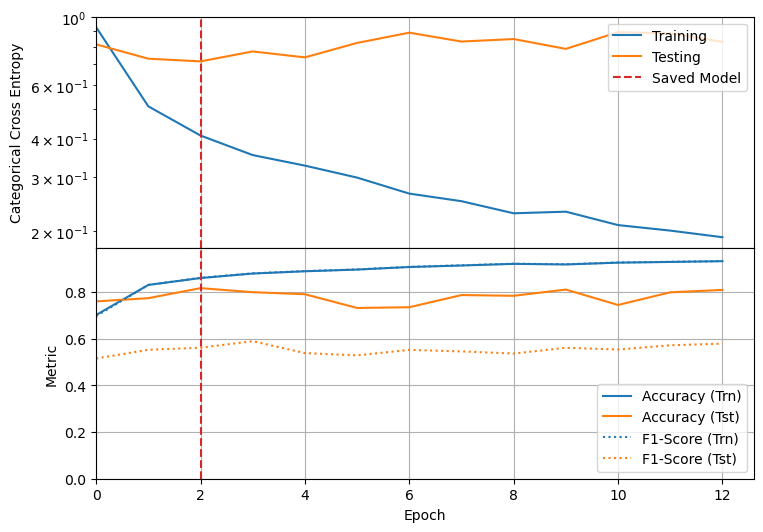

In [15]:
fig = dplt.plot_loss(log, scale=6)
fig.show()

## Confusion Matrix

In [16]:
Ptrn = model.predict(Xtrn)
Ptst = model.predict(Xtst)

Ptrn_flat = np.argmax(Ptrn, axis=1)
Ptst_flat = np.argmax(Ptst, axis=1)

Ytrn_flat = np.argmax(Ytrn, axis=1)
Ytst_flat = np.argmax(Ytst, axis=1)

SNtypes_int = np.unique(Ytrn_flat)
SNtypes_str = [scs_config.SN_Stypes_int_to_str[sn] for sn in SNtypes_int]

CMtrn = confusion_matrix(Ytrn_flat, Ptrn_flat)
CMtst = confusion_matrix(Ytst_flat, Ptst_flat)

62/62 [==============================] - 0s 1ms/step


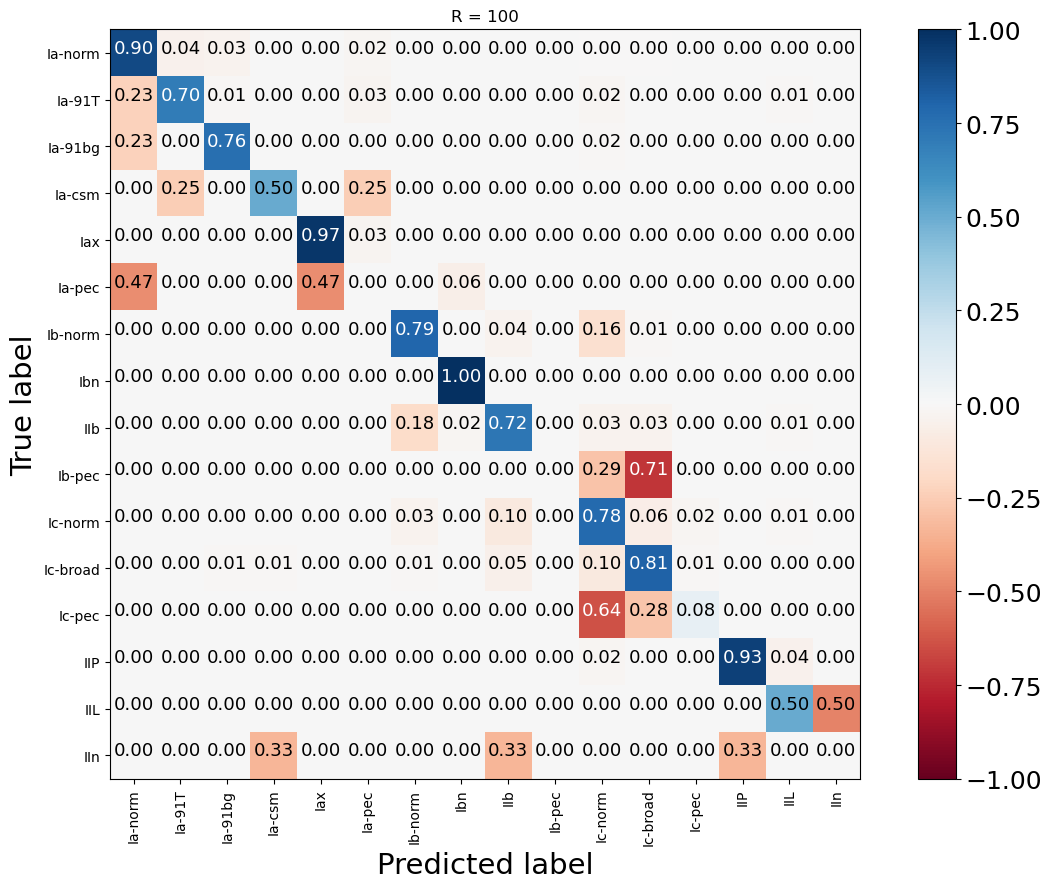

In [17]:
dplt.plot_cm(CMtst, SNtypes_str, R, normalize=True)
# dplt.plot_cm(CMtrn, SNtypes_str, R, normalize=True)